In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)

In [2]:
train = pd.read_csv("../Part 1_Data Preprocessing/train_data_processed.csv")
train.head()

,City_Name,Latitude,Longitude,Population,Density,Visibility,Precipitation_Probability,DateTime,Temperature,Feels_Like_Temperature,Pressure,Ground_Level_Pressure,Humidity,Cloud_Coverage,Wind_Speed,Wind_Direction,Wind_Gust,Weather_Description,Hour,City_Tier,Part_of_Day,Rain_Snow_Likelihood,Wind_Chill_Factor
0,New York,40.7143,-74.006,18908608.0,11226.2,High,0.0,2023-11-29 03:00:00,273.13,267.10,1016,1017,50,0,7.25,280,12.91,Clear,3,Tier 1,Night,Low,332.008753
1,New York,40.7143,-74.006,18908608.0,11226.2,High,0.0,2023-11-29 06:00:00,273.04,267.15,1017,1017,49,1,6.88,278,12.48,Clear,6,Tier 1,Morning,Low,330.837282
2,New York,40.7143,-74.006,18908608.0,11226.2,High,0.0,2023-11-29 09:00:00,272.59,266.95,1018,1019,52,2,6.07,278,9.18,Clear,9,Tier 1,Morning,Low,327.777334
3,New York,40.7143,-74.006,18908608.0,11226.2,High,0.0,2023-11-29 12:00:00,272.21,267.09,1021,1020,52,5,4.94,272,7.52,Clear,12,Tier 1,Afternoon,Low,323.326935
4,New York,40.7143,-74.006,18908608.0,11226.2,High,0.0,2023-11-29 15:00:00,273.48,268.73,1021,1021,46,22,4.85,255,6.23,Clouds,15,Tier 1,Afternoon,Low,324.563477


In [3]:
test = pd.read_csv("../Part 1_Data Preprocessing/test_data_processed.csv")
test.head()

,City_Name,Latitude,Longitude,Population,Density,Visibility,Precipitation_Probability,DateTime,Temperature,Feels_Like_Temperature,Pressure,Ground_Level_Pressure,Humidity,Cloud_Coverage,Wind_Speed,Wind_Direction,Wind_Gust,Weather_Description,Hour,City_Tier,Part_of_Day,Rain_Snow_Likelihood,Wind_Chill_Factor
0,New York,40.7143,-74.006,18908608.0,11226.2,High,1.00,2023-12-04 03:00:00,282.73,281.36,1003,1002,96,100,2.67,284,4.82,Rain,3,Tier 1,Night,Moderate,324.749724
1,New York,40.7143,-74.006,18908608.0,11226.2,High,0.74,2023-12-04 06:00:00,282.88,280.41,1003,1003,94,85,4.98,267,12.62,Clouds,6,Tier 1,Morning,Moderate,336.819362
2,New York,40.7143,-74.006,18908608.0,11226.2,High,0.00,2023-12-04 09:00:00,282.95,280.05,1005,1004,80,1,6.28,260,13.59,Clear,9,Tier 1,Morning,Low,341.644676
3,New York,40.7143,-74.006,18908608.0,11226.2,High,0.00,2023-12-04 12:00:00,281.99,278.87,1007,1006,71,2,6.16,253,11.74,Clear,12,Tier 1,Afternoon,Low,340.022767
4,New York,40.7143,-74.006,18908608.0,11226.2,High,0.00,2023-12-04 15:00:00,282.75,279.83,1008,1007,60,10,6.18,272,9.66,Clear,15,Tier 1,Afternoon,Low,341.056640


In [4]:
# dropping columns not needed for ML
train.drop(columns=['DateTime','Latitude','Longitude',"City_Name"],inplace=True)
test.drop(columns=['DateTime','Latitude','Longitude',"City_Name"],inplace=True)

In [5]:
X= train.drop(columns=["Weather_Description"])
y= train["Weather_Description"]

X_test_final= test.drop(columns=["Weather_Description"])
y_test_final= test["Weather_Description"]

In [6]:
# encoding y labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y_test_final = encoder.transform(y_test_final)

In [7]:
# checking the encoding map
# Access the mapping
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

# Print the mapping
print(label_mapping)

{'Clear': 0, 'Clouds': 1, 'Rain': 2, 'Snow': 3}


In [8]:
# one-hot encode categorical variable
X = pd.get_dummies(X,dtype=int)
X_test_final = pd.get_dummies(X_test_final,dtype=int)

In [9]:
# standardizing the predictor variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_final_scaled= scaler.transform(X_test_final)

### Part 1: Running Multiple Classification Models and Gauging the performance (Accuracy and F1 Score is going to be monitored)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [11]:
# to keep track of evaluations we are going to create the following dictionary
eval ={"model_name":[],
       "f1-score on class 0 (Clear)":[],
       "f1-score on class 1 (Clouds)":[],
       "f1-score on class 2 (Rain)":[],
       "f1-score on class 3 (Snow)":[],
       "accuracy":[]
       }

Model1: Logistic Regression

In [12]:
model = LogisticRegression(multi_class="multinomial",solver="newton-cg")
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1133    0    1    0]
 [  16 3929   97    8]
 [   3  115  981    5]
 [   0   16   21  115]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1134
           1       0.97      0.97      0.97      4050
           2       0.89      0.89      0.89      1104
           3       0.90      0.76      0.82       152

    accuracy                           0.96      6440
   macro avg       0.94      0.90      0.92      6440
weighted avg       0.96      0.96      0.96      6440



In [13]:
eval["model_name"].append("Logistic Regression")
for i in range(4):
    score = classification_report(y_test,y_pred,output_dict=True)[str(i)]["f1-score"]
    for key in eval:
        if " "+str(i)+" " in key:
            eval[key].append(score)
            break

accuracy = classification_report(y_test,y_pred,output_dict=True)["accuracy"]
eval["accuracy"].append(accuracy)

In [14]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1132    0    2    0]
 [   0 3977   64    9]
 [   0   84 1012    8]
 [   0   14   11  127]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1134
           1       0.98      0.98      0.98      4050
           2       0.93      0.92      0.92      1104
           3       0.88      0.84      0.86       152

    accuracy                           0.97      6440
   macro avg       0.95      0.93      0.94      6440
weighted avg       0.97      0.97      0.97      6440



In [15]:
eval["model_name"].append("Decision Tree")
for i in range(4):
    score = classification_report(y_test,y_pred,output_dict=True)[str(i)]["f1-score"]
    for key in eval:
        if " "+str(i)+" " in key:
            eval[key].append(score)
            break

accuracy = classification_report(y_test,y_pred,output_dict=True)["accuracy"]
eval["accuracy"].append(accuracy)

In [16]:
model = GaussianNB()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1130    4    0    0]
 [ 490 3360   52  148]
 [   0  290  611  203]
 [   0    7    1  144]]
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      1134
           1       0.92      0.83      0.87      4050
           2       0.92      0.55      0.69      1104
           3       0.29      0.95      0.45       152

    accuracy                           0.81      6440
   macro avg       0.71      0.83      0.71      6440
weighted avg       0.86      0.81      0.82      6440



In [17]:
eval["model_name"].append("Naive Bayes")
for i in range(4):
    score = classification_report(y_test,y_pred,output_dict=True)[str(i)]["f1-score"]
    for key in eval:
        if " "+str(i)+" " in key:
            eval[key].append(score)
            break

accuracy = classification_report(y_test,y_pred,output_dict=True)["accuracy"]
eval["accuracy"].append(accuracy)

(1, 0.9238268105891574, 0.0048532297549091765)

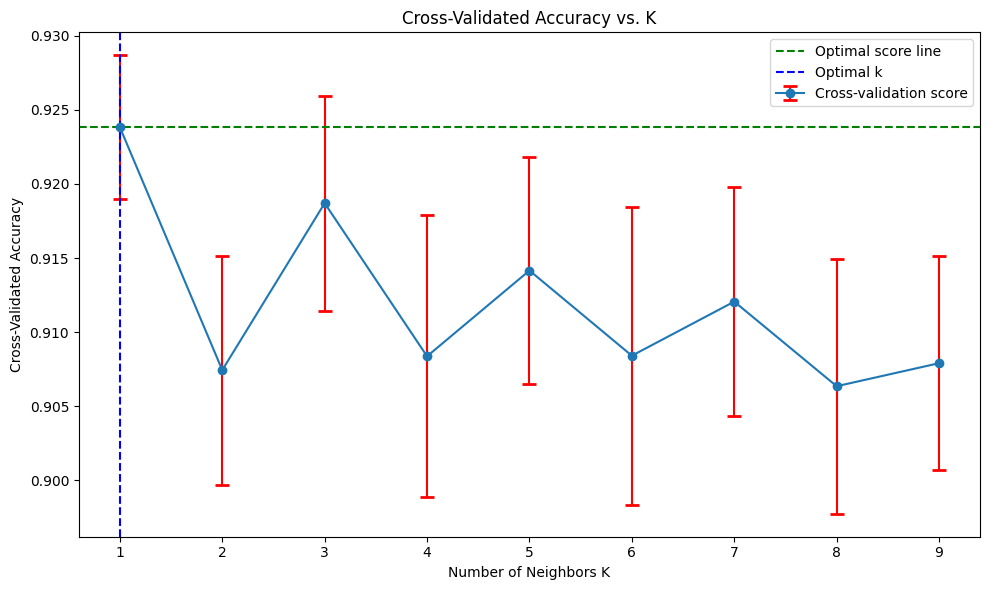

In [18]:
# Choosing the optimal k using cross-validation and visualizing the results

# List to hold the average cross-validation scores
cv_scores = []

# List to hold the standard deviation of cross-validation scores
cv_std = []

# List of k values to try
k_values = list(range(1, 10))

# Perform 10-fold cross-validation with different values of k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    cv_std.append(scores.std())

# Determine the best k (lowest cross-validation error)
optimal_k = k_values[cv_scores.index(max(cv_scores))]
optimal_score = max(cv_scores)
optimal_std = cv_std[cv_scores.index(max(cv_scores))]

# Generate the plot
plt.figure(figsize=(10,6))
plt.errorbar(k_values, cv_scores, yerr=cv_std, fmt='o-', ecolor='red', capsize=5, capthick=2, label='Cross-validation score')
plt.axhline(y=optimal_score, color='green', linestyle='--', label='Optimal score line')
plt.axvline(x=optimal_k, color='blue', linestyle='--', label='Optimal k')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Cross-Validated Accuracy vs. K')
plt.legend()
plt.tight_layout()

# Display the optimal k value and its score
optimal_k, optimal_score, optimal_std


In [19]:
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1012  119    3    0]
 [ 139 3830   73    8]
 [   2   85 1004   13]
 [   0   25   12  115]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1134
           1       0.94      0.95      0.94      4050
           2       0.92      0.91      0.91      1104
           3       0.85      0.76      0.80       152

    accuracy                           0.93      6440
   macro avg       0.90      0.88      0.89      6440
weighted avg       0.93      0.93      0.93      6440



In [20]:
eval["model_name"].append("K Nearest Neighbors")
for i in range(4):
    score = classification_report(y_test,y_pred,output_dict=True)[str(i)]["f1-score"]
    for key in eval:
        if " "+str(i)+" " in key:
            eval[key].append(score)
            break

accuracy = classification_report(y_test,y_pred,output_dict=True)["accuracy"]
eval["accuracy"].append(accuracy)

In [21]:
model = RandomForestClassifier(random_state=42,bootstrap=True)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1132    0    2    0]
 [   0 3962   80    8]
 [   0    9 1091    4]
 [   0   11    8  133]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1134
           1       0.99      0.98      0.99      4050
           2       0.92      0.99      0.95      1104
           3       0.92      0.88      0.90       152

    accuracy                           0.98      6440
   macro avg       0.96      0.96      0.96      6440
weighted avg       0.98      0.98      0.98      6440



In [22]:
eval["model_name"].append("Random Forest")
for i in range(4):
    score = classification_report(y_test,y_pred,output_dict=True)[str(i)]["f1-score"]
    for key in eval:
        if " "+str(i)+" " in key:
            eval[key].append(score)
            break

accuracy = classification_report(y_test,y_pred,output_dict=True)["accuracy"]
eval["accuracy"].append(accuracy)

In [23]:
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1132    0    2    0]
 [   0 3938  104    8]
 [   0    7 1090    7]
 [   0   14   11  127]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1134
           1       0.99      0.97      0.98      4050
           2       0.90      0.99      0.94      1104
           3       0.89      0.84      0.86       152

    accuracy                           0.98      6440
   macro avg       0.95      0.95      0.95      6440
weighted avg       0.98      0.98      0.98      6440



In [24]:
eval["model_name"].append("Gradient Boosting")
for i in range(4):
    score = classification_report(y_test,y_pred,output_dict=True)[str(i)]["f1-score"]
    for key in eval:
        if " "+str(i)+" " in key:
            eval[key].append(score)
            break

accuracy = classification_report(y_test,y_pred,output_dict=True)["accuracy"]
eval["accuracy"].append(accuracy)

In [25]:
model = XGBClassifier(random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1132    0    2    0]
 [   0 3975   67    8]
 [   0   20 1075    9]
 [   0    9   11  132]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1134
           1       0.99      0.98      0.99      4050
           2       0.93      0.97      0.95      1104
           3       0.89      0.87      0.88       152

    accuracy                           0.98      6440
   macro avg       0.95      0.96      0.95      6440
weighted avg       0.98      0.98      0.98      6440



In [26]:
eval["model_name"].append("Extreme Gradient Boosting")
for i in range(4):
    score = classification_report(y_test,y_pred,output_dict=True)[str(i)]["f1-score"]
    for key in eval:
        if " "+str(i)+" " in key:
            eval[key].append(score)
            break

accuracy = classification_report(y_test,y_pred,output_dict=True)["accuracy"]
eval["accuracy"].append(accuracy)

In [27]:
model = CatBoostClassifier(random_state=42,verbose=0)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1133    0    1    0]
 [   0 3970   74    6]
 [   0   21 1077    6]
 [   0   13    7  132]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1134
           1       0.99      0.98      0.99      4050
           2       0.93      0.98      0.95      1104
           3       0.92      0.87      0.89       152

    accuracy                           0.98      6440
   macro avg       0.96      0.96      0.96      6440
weighted avg       0.98      0.98      0.98      6440



In [28]:
eval["model_name"].append("Cat Boosting")
for i in range(4):
    score = classification_report(y_test,y_pred,output_dict=True)[str(i)]["f1-score"]
    for key in eval:
        if " "+str(i)+" " in key:
            eval[key].append(score)
            break

accuracy = classification_report(y_test,y_pred,output_dict=True)["accuracy"]
eval["accuracy"].append(accuracy)

In [29]:
evaluation1 = pd.DataFrame(eval).sort_values(by="accuracy",ascending=False).reset_index(drop=True)
evaluation1

,model_name,f1-score on class 0 (Clear),f1-score on class 1 (Clouds),f1-score on class 2 (Rain),f1-score on class 3 (Snow),accuracy
0,Random Forest,0.999117,0.986554,0.954923,0.895623,0.981056
1,Extreme Gradient Boosting,0.999117,0.987087,0.951749,0.877076,0.980435
2,Cat Boosting,0.999559,0.985846,0.951834,0.891892,0.980124
3,Gradient Boosting,0.999117,0.983394,0.943315,0.863946,0.976242
4,Decision Tree,0.999117,0.978954,0.922937,0.858108,0.970186
5,Logistic Regression,0.991251,0.968927,0.890200,0.821429,0.956211
6,K Nearest Neighbors,0.885002,0.944629,0.914390,0.798611,0.925621
7,Naive Bayes,0.820625,0.871482,0.691176,0.445131,0.814441


### Selecting our top 3 best performing model (ensemble them)

In [30]:
from sklearn.ensemble import  VotingClassifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(random_state=42)
catboost = CatBoostClassifier(random_state=42, verbose=0) 

In [31]:
# Create the voting classifier
voting_clf = VotingClassifier(
    estimators=[('rf', random_forest), ('xgb', xgb), ('catboost', catboost)],
    voting='soft'  # or 'soft' if you want to average probabilities
)
# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Predict and evaluate the classifier
y_pred = voting_clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1132    0    2    0]
 [   0 3969   74    7]
 [   0   12 1087    5]
 [   0    9    9  134]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1134
           1       0.99      0.98      0.99      4050
           2       0.93      0.98      0.96      1104
           3       0.92      0.88      0.90       152

    accuracy                           0.98      6440
   macro avg       0.96      0.96      0.96      6440
weighted avg       0.98      0.98      0.98      6440



In [32]:
eval["model_name"].append("RandomForest + XGB + CatBoost")
for i in range(4):
    score = classification_report(y_test,y_pred,output_dict=True)[str(i)]["f1-score"]
    for key in eval:
        if " "+str(i)+" " in key:
            eval[key].append(score)
            break

accuracy = classification_report(y_test,y_pred,output_dict=True)["accuracy"]
eval["accuracy"].append(accuracy)

In [33]:
evaluation1 = pd.DataFrame(eval).sort_values(by="accuracy",ascending=False).reset_index(drop=True)
evaluation1

,model_name,f1-score on class 0 (Clear),f1-score on class 1 (Clouds),f1-score on class 2 (Rain),f1-score on class 3 (Snow),accuracy
0,RandomForest + XGB + CatBoost,0.999117,0.987313,0.955185,0.899329,0.981677
1,Random Forest,0.999117,0.986554,0.954923,0.895623,0.981056
2,Extreme Gradient Boosting,0.999117,0.987087,0.951749,0.877076,0.980435
3,Cat Boosting,0.999559,0.985846,0.951834,0.891892,0.980124
4,Gradient Boosting,0.999117,0.983394,0.943315,0.863946,0.976242
5,Decision Tree,0.999117,0.978954,0.922937,0.858108,0.970186
6,Logistic Regression,0.991251,0.968927,0.890200,0.821429,0.956211
7,K Nearest Neighbors,0.885002,0.944629,0.914390,0.798611,0.925621
8,Naive Bayes,0.820625,0.871482,0.691176,0.445131,0.814441


### Evaluating Performance on Test Set (Checking for Overfitting/Underfitting)

In [34]:
# to keep track of evaluations we are going to create the following dictionary
eval2 ={"model_name":[],
       "f1-score on class 0 (Clear)":[],
       "f1-score on class 1 (Clouds)":[],
       "f1-score on class 2 (Rain)":[],
       "f1-score on class 3 (Snow)":[],
       "train_accuracy":[],
       "test_accuracy":[]
       }

In [35]:
# 1. Catboost
eval2["model_name"].append("Cat Boosting")
model = CatBoostClassifier(random_state=42,verbose=0)
model.fit(X_scaled,y)

# train accuracy
y_pred = model.predict(X_scaled)
train_accuracy = accuracy_score(y,y_pred)
eval2["train_accuracy"].append(train_accuracy)

# test accuracy
y_pred = model.predict(X_test_final_scaled)
for i in range(4):
    score = classification_report(y_test_final,y_pred,output_dict=True)[str(i)]["f1-score"]
    for key in eval:
        if " "+str(i)+" " in key:
            eval2[key].append(score)
            break

accuracy = classification_report(y_test_final,y_pred,output_dict=True)["accuracy"]
eval2["test_accuracy"].append(accuracy)

In [36]:
# 2. Extreme Gradient Boosting
eval2["model_name"].append("Extreme Gradient Boosting")
model = XGBClassifier(random_state=42)
model.fit(X_scaled,y)

# train accuracy
y_pred = model.predict(X_scaled)
train_accuracy = accuracy_score(y,y_pred)
eval2["train_accuracy"].append(train_accuracy)

# test accuracy
y_pred = model.predict(X_test_final_scaled)
for i in range(4):
    score = classification_report(y_test_final,y_pred,output_dict=True)[str(i)]["f1-score"]
    for key in eval:
        if " "+str(i)+" " in key:
            eval2[key].append(score)
            break

accuracy = classification_report(y_test_final,y_pred,output_dict=True)["accuracy"]
eval2["test_accuracy"].append(accuracy)

In [37]:
# 3. Random Forest Classifier
eval2["model_name"].append("Random Forest")
model = RandomForestClassifier(random_state=42)
model.fit(X_scaled,y)

# train accuracy
y_pred = model.predict(X_scaled)
train_accuracy = accuracy_score(y,y_pred)
eval2["train_accuracy"].append(train_accuracy)

# test accuracy
y_pred = model.predict(X_test_final_scaled)
for i in range(4):
    score = classification_report(y_test_final,y_pred,output_dict=True)[str(i)]["f1-score"]
    for key in eval:
        if " "+str(i)+" " in key:
            eval2[key].append(score)
            break

accuracy = classification_report(y_test_final,y_pred,output_dict=True)["accuracy"]
eval2["test_accuracy"].append(accuracy)

In [38]:
#4. RandomForest + XGB + CatBoost	
eval2["model_name"].append("RandomForest + XGB + CatBoost")
voting_clf.fit(X_scaled,y)

# train accuracy
y_pred = voting_clf.predict(X_scaled)
train_accuracy = accuracy_score(y,y_pred)
eval2["train_accuracy"].append(train_accuracy)

# test accuracy
y_pred = voting_clf.predict(X_test_final_scaled)
for i in range(4):
    score = classification_report(y_test_final,y_pred,output_dict=True)[str(i)]["f1-score"]
    for key in eval:
        if " "+str(i)+" " in key:
            eval2[key].append(score)
            break

accuracy = classification_report(y_test_final,y_pred,output_dict=True)["accuracy"]
eval2["test_accuracy"].append(accuracy)

In [39]:
evaluation2 = pd.DataFrame(eval2).sort_values(by="test_accuracy",ascending=False).reset_index(drop=True)
evaluation2

,model_name,f1-score on class 0 (Clear),f1-score on class 1 (Clouds),f1-score on class 2 (Rain),f1-score on class 3 (Snow),train_accuracy,test_accuracy
0,Random Forest,0.998141,0.981414,0.875000,0.453333,1.000000,0.964953
1,RandomForest + XGB + CatBoost,0.998141,0.979830,0.869565,0.478873,0.999503,0.963530
2,Cat Boosting,0.998141,0.979834,0.867151,0.459459,0.996180,0.962996
3,Extreme Gradient Boosting,0.998141,0.977550,0.859239,0.485714,0.999783,0.960683


In [40]:
evaluation1.to_csv("train_validation_eval.csv",index=False)
evaluation2.to_csv("train_test_eval.csv",index=False)

### Saving Model Predcitions for User Application

In [41]:
#saving best model's predictions
predictions = encoder.inverse_transform(y_pred)

In [42]:
test = pd.read_csv("../Part 1_Data Preprocessing/test_data_processed.csv")
forecast_data = test[["City_Name","DateTime"]]

In [43]:
forecast_data.head()

,City_Name,DateTime
0,New York,2023-12-04 03:00:00
1,New York,2023-12-04 06:00:00
2,New York,2023-12-04 09:00:00
3,New York,2023-12-04 12:00:00
4,New York,2023-12-04 15:00:00


In [44]:
forecast_data.shape

(5621, 2)

In [45]:
forecast_data["Weather_Description"]=predictions
forecast_data.head()

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_9072\3560219906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_data["Weather_Description"]=predictions


,City_Name,DateTime,Weather_Description
0,New York,2023-12-04 03:00:00,Rain
1,New York,2023-12-04 06:00:00,Rain
2,New York,2023-12-04 09:00:00,Clear
3,New York,2023-12-04 12:00:00,Clear
4,New York,2023-12-04 15:00:00,Clear


In [46]:
forecast_data.to_csv("forecast_data.csv",index=False)